# Notebook to replicate our paper's quantitative analysis

- Author: Hadi Asghari & Freya Hewett
- Version: 2023.02

The first part of this notebook takes as input the classified Oscar22 DE-subset pages.

The second part uses the LS-scraper results. It also makes use of Language Tool's API (explained further below). 



In [2]:
from collections import Counter
import os
import requests
import json
import pandas as pd
from scipy import stats
import numpy as np


## Part I: analysis of web classification per domain category

In [28]:
# LOAD DATA
df = pd.read_csv("./data/oscar22-classified.csv.xz", sep='\t')

# or if recreating: 
# df = pd.read_csv("oscar-classified.csv", sep='\t', 
#                  names=['url', 'domain', 'domcat', 'readability', 'easy_score', 'clen'])
# df = df[df.domain.str.endswith('de')]   

print(len(df))
df.head(3)

16658597


,url,domain,domcat,readability,easy_score,clen
0,http://cvd.bundesregierung.de/cvd-de/datenschu...,bundesregierung.de,Government,11.3,0.000,31200
1,http://demo.feuerwehr-kernen.de/fahrzeuge/eins...,feuerwehr-kernen.de,Society,13.3,0.000,7318
2,http://dl.ub.uni-freiburg.de/diglit/bibl_freim...,uni-freiburg.de,Education,13.3,0.097,202


In [29]:
# spearman rho correlation between:
# - the wiener_sachtextformel readibility score 
# - and our easy german classifier score
# for cases where the readibility score is valid (among 5m randomly selected)
t = df[(1<df.readability)&(df.readability<20)]
stats.spearmanr(t.readability, t.easy_score)

# SignificanceResult(statistic=-0.4196474128263441, pvalue=0.0)

SignificanceResult(statistic=-0.4196474128263441, pvalue=0.0)

In [30]:
# Calculate percentage of 'easy' URLs/Domains (per category)

# add columns
df['is_easy'] = df['easy_score'] >= 0.8  
#df['url_leicht'] = df.url.str.contains('leicht.+sprach', case=False)
# let's combine a few categories for easier presentation
df.loc[df.domcat=='Government', 'domcat'] = 'Gov/Region'
df.loc[df.domcat=='RegOther', 'domcat'] = 'Gov/Region'
df.loc[df.domcat=='Arts', 'domcat'] = 'Recreation'
df.loc[df.domcat=='Education', 'domcat'] = 'Science'
df.loc[df.domcat=='Home', 'domcat'] = 'Recreation'

# URLs & domains per category
tb2 = df.groupby('domcat').url.count().to_frame()
tb2['domain'] = df.groupby('domcat').domain.nunique()

# counts of only easy pages (and their domains)
tb2['url_easy'] = df[df.is_easy].groupby('domcat').url.count()
#tb['domain_weasy'] = df[df.is_easy].groupby('domcat').domain.nunique()
tb2['perc_easy_u'] = tb2['url_easy'] / tb2['url']
del tb2['url_easy']

# print
# one interesting finding is that so little of government urls is basic :)
print(tb2.sort_values('perc_easy_u'))

#  url  domain  perc_easy_u
# domcat
# Science        2859859    7483     0.043210
# Gov_or_Region  2617151   24467     0.071892
# Business       1738920   36666     0.094679
# Shopping        642924    4812     0.181794
# Health          700874   12138     0.186790
# Society        1471080   15748     0.189874
# Computers       763282    3841     0.190214
# Recreation     2805087   28243     0.199405
# Travel          470097    9290     0.215796
# Kids            182729     864     0.248570
# Games           267319    1413     0.294192
# News           2139275    1236     0.305110

                url  domain  perc_easy_u
domcat                                  
Science     2859859    7483     0.043210
Gov/Region  2617151   24467     0.071892
Business    1738920   36666     0.094679
Shopping     642924    4812     0.181794
Health       700874   12138     0.186790
Society     1471080   15748     0.189874
Computers    763282    3841     0.190214
Recreation  2805087   28243     0.199405
Travel       470097    9290     0.215796
Kids         182729     864     0.248570
Games        267319    1413     0.294192
News        2139275    1236     0.305110


In [10]:
# output for latex
print(tb2.sort_values('perc_easy_u').to_latex())

\begin{tabular}{lrrr}
\toprule
{} &      url &  domain &  perc\_easy\_u \\
domcat        &          &         &              \\
\midrule
Science       &  2859859 &    7483 &     0.043191 \\
Gov\_or\_Region &  2617151 &   24467 &     0.071788 \\
Business      &  1738920 &   36666 &     0.094636 \\
Shopping      &   642924 &    4812 &     0.181726 \\
Health        &   700874 &   12138 &     0.186744 \\
Society       &  1471080 &   15748 &     0.189807 \\
Computers     &   763282 &    3841 &     0.190128 \\
Recreation    &  2805087 &   28243 &     0.199335 \\
Travel        &   470097 &    9290 &     0.215698 \\
Kids          &   182729 &     864 &     0.248548 \\
Games         &   267319 &    1413 &     0.294106 \\
News          &  2139275 &    1236 &     0.305004 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_67349/58578050.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tb2.sort_values('perc_easy_u').to_latex())


0.15524968879432044


<Axes: xlabel='domcat'>

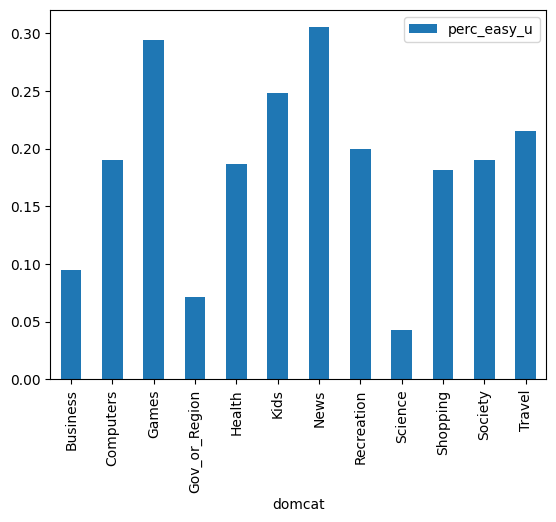

In [7]:
# total stats & plot
print(sum(df.is_easy)/len(df))
tb2.get(['perc_easy_u']).plot(kind='bar')

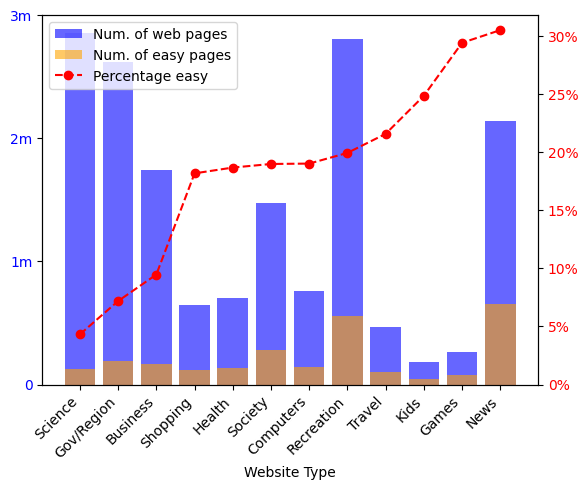

In [39]:
# Additional graphical representations of T1
# Bar chart with primary and secondary y-axes (stacked) plus a line chart?

# Version of above with an additional stacked barchart added for num-of-easy-pages

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# Calculate num_easy_pages
tb2['num_easy_pages'] = tb2['url'] * tb2['perc_easy_u']

# Sort the data by % easy pages
data = tb2.sort_values(by='perc_easy_u')

fig, ax1 = plt.subplots()

# Bar chart (num_of_pages)
ax1.bar(data.index, data.url, color='b', alpha=0.6, label='Num. of web pages')

# Bar chart (num_easy_pages)
ax1.bar(data.index, data.num_easy_pages, color='orange', alpha=0.6, label='Num. of easy pages')

ax1.set_xlabel('Website Type')
#ax1.set_ylabel('N. of web pages', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Set y-axis limits and ticks for num_of_pages
ax1.set_ylim(bottom=0)
ax1.set_yticks([0, 1_000_000, 2_000_000, 3_000_000])
ax1.set_yticklabels(['0', '1m', '2m', '3m'])

# Line chart (% easy pages)
ax2 = ax1.twinx()
ax2.plot(data.index, np.array(data.perc_easy_u) * 100, 'r', marker='o', linestyle='--', label='Percentage easy')
#ax2.set_ylabel('% easy pages', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Set y-axis limits and ticks for percent_easy_pages
ax2.set_ylim(bottom=0)
ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.0f%%'))
ax2.set_yticks(range(0, 31, 5))

# Tilt category names
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

# Display legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

#plt.title('Num of Pages, Num of Easy Pages, and % Easy Pages by Website Type (Ordered by % Easy Pages)')
plt.savefig('/home/hadi/lsweb-barchart2.png', dpi=300, bbox_inches='tight')

plt.show()

## Part II: Analysis of LS web crawl

We estimate the coverage/comprehensivenss of the Oscar (Common Crawl) by calculating what percentage of the LS URLs our crawler finds (which are among the public sector websites shared with us) exist in our Oscar subset.

Due to anonimity of the states, we cannot share the list of found URLs. However, the results are as follows:

- 11 of the public sector domains are missing in the subset—this is probably a curlie issue rather than Oscar
- Among the remainder, out of 310 found URLs, only 9 appear in the subset. This is a crawler coverage issue


In [11]:
# import tldextract
# from urllib.parse import urlparse

# lszero =  open("./data/found-lsurls-excluded.txt").readlines()

# if not 'urls' in locals():
#     urls = set(df.url)
#     domains = set(df.domain)

# u_in, u_out = [], []
# d_in, d_out = set(), set()

# for u in lszero:
#     u = u.strip()
#     d = tldextract.extract(urlparse(u).netloc).registered_domain
#     if d in domains:
#         d_in.add(d)
#         if u in urls:
#             u_in.append(u)
#         else:
#             u_out.append(u)
#     else:
#         d_out.add(d)


# print('domains:', len(d_in), len(d_out))
# print('urls:', len(u_in), len(u_out), )

**Table 2**

To calculate the number of domains that have LS pages (which are presented in Table 2), please refer to the results/output-log of the crawler.

Regarding the LS quality aspect on the pages found, the following cell calculates the amount of times that a [Leichte Sprache rule](https://languagetool.org/de/leichte-sprache) is broken. The input web pages have been saved as text files by the web crawler. The rule check code uses the [Language Tool API](https://dev.languagetool.org/public-http-api), which we recommend [installing locally](https://dev.languagetool.org/http-server). 





In [ ]:
inputdir = "./crawler/savedpages/"  # path where input files are saved
outputfile = "output_file.csv" # path to output csv file
bundesland = "bundesland" # first column in output csv file

texts = dict()
filenames = os.listdir(inputdir)
for fn in filenames:
    if fn.endswith('.txt'):
        with open(inputdir + fn, 'r') as in_file:
            text = in_file.readlines()
            body = ' '.join(text[1:])
            body = body.replace('\n', '')
            # replace * and # because they count as sonderzeichen
            body = body.replace('*', '')
            body = body.replace('#', '')
            texts[text[0].strip()] = body

all_counters = dict()

for i,t in enumerate(texts):
    if i% 10 == 0:
        print(str(i), " texts parsed")

    # Get length of text (characters)
    length = len(texts[t])

    headers = {'Content-Type': 'application/x-www-form-urlencoded',}
    data = 'text=' + texts[t] + '&language=de-DE-x-simple-language'

    # We recommend setting up your own LanguageTool server for speed/reliability. 
    # If you are just trying out one text, you can use the public API: https://api.languagetool.org/v2/check
    # (but please note the restrictions)
    response = requests.post('http://localhost:8081/v2/check', headers=headers, data=data.encode('utf-8'))
    print(response.status_code)
    if response.status_code != 400:
        output = response.json()
    else:
        print(i)
        continue

    rule_breaks = Counter()
    for matches in output['matches']:
        rule_breaks[matches['rule']['id']] += 1

    #Total rule breaks
    total_rule_breaks = sum(rule_breaks.values())

    #Unique rule breaks
    unique_rule_breaks = len(list(rule_breaks))

    #Top 3 rule breaks
    top_3 = rule_breaks.most_common(3)

    all_counters[t] = rule_breaks

    #CSV file with: URL, length of text in characters, total rule breaks, unique rule breaks,
    with open(outputfile, 'a') as output:
        print(bundesland+','+t+','+str(length)+','+str(total_rule_breaks)+','+str(unique_rule_breaks)+',"'+str(top_3)+'"',file=output)

    json.dump(all_counters, open('counter_' + bundesland + '.json', 'w'))
